In [1]:
import os
from pathlib import Path

# 方法 1：相對於 notebook 位置
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # 從 model/aapl 往上兩層
os.chdir(project_root)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np
import ta

In [3]:
df = pd.read_csv("data/AAPL.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14)
df['k'] = stoch.stoch()
df['d'] = stoch.stoch_signal()
df

,Close,High,Low,Open,Volume,rsi,k,d
Date,,,,,,,,
2014-01-06,16.871346,16.960365,16.550935,16.670353,412610800,NaN,NaN,NaN
2014-01-07,16.750681,16.934304,16.684924,16.883435,317209200,NaN,NaN,NaN
2014-01-08,16.856766,16.921901,16.708813,16.712533,258529600,NaN,NaN,NaN
2014-01-09,16.641502,16.962223,16.605212,16.960361,279148800,NaN,NaN,NaN
2014-01-10,16.530458,16.774256,16.473696,16.744168,304976000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-22,191.788773,193.581837,191.164662,193.353978,37149600,54.672823,36.229135,52.092899
2023-12-26,191.243927,192.076065,191.025984,191.798686,28919300,53.090083,19.878370,38.505327
2023-12-27,191.342941,191.689673,189.302216,190.689128,48087700,53.354360,24.149983,26.752496


In [4]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day, 0])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Volume','rsi','k','d']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 5 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)




(2514, 4)


In [5]:
X_train.shape

torch.Size([1996, 40, 4])

In [6]:
Y_train

tensor([[0.0061, 0.0059, 0.0058, 0.0059, 0.0068],
        [0.0059, 0.0058, 0.0059, 0.0068, 0.0069],
        [0.0058, 0.0059, 0.0068, 0.0069, 0.0058],
        ...,
        [0.8604, 0.8671, 0.8511, 0.8496, 0.8456],
        [0.8671, 0.8511, 0.8496, 0.8456, 0.8628],
        [0.8511, 0.8496, 0.8456, 0.8628, 0.8707]])

In [7]:

class LSTM(nn.Module):
    def __init__(self, n_features, hidden_dim, predict_day):
        super(LSTM, self).__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.predict_day = predict_day
        
        self.lstm = nn.LSTM(input_size=self.n_features, hidden_size=self.hidden_dim, 
                            num_layers=2, bidirectional=False, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(self.hidden_dim, self.predict_day)
        
    def forward(self, x): 
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1,:]) #取最後一個state
        
        return x


In [8]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 0.001

# 初始化模型、損失函數和優化器
model = LSTM(n_features=4, hidden_dim=128, predict_day=5)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [9]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_val_loss = float('inf')
best_model_path = "output/model/aapl/lstm_5.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch= x_batch.to(device)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    '''
    if val_loss < min_val_loss and epoch>50:
        min_val_loss = val_loss
        torch.save(model, best_model_path) 
        print(f"Model saved with val_loss: {val_loss:.4f}")
    '''
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save(model, best_model_path)



Epoch [1/100], Train Loss: 0.0026, Val Loss: 0.0040
Epoch [2/100], Train Loss: 0.0267, Val Loss: 0.0064
Epoch [3/100], Train Loss: 0.0728, Val Loss: 0.0617
Epoch [4/100], Train Loss: 0.0654, Val Loss: 0.0325
Epoch [5/100], Train Loss: 0.0739, Val Loss: 0.2147
Epoch [6/100], Train Loss: 0.0269, Val Loss: 0.0236
Epoch [7/100], Train Loss: 0.0138, Val Loss: 0.0084
Epoch [8/100], Train Loss: 0.0033, Val Loss: 0.0152
Epoch [9/100], Train Loss: 0.0017, Val Loss: 0.0013
Epoch [10/100], Train Loss: 0.0040, Val Loss: 0.0057
Epoch [11/100], Train Loss: 0.0015, Val Loss: 0.0023
Epoch [12/100], Train Loss: 0.0021, Val Loss: 0.0045
Epoch [13/100], Train Loss: 0.0010, Val Loss: 0.0023
Epoch [14/100], Train Loss: 0.0012, Val Loss: 0.0021
Epoch [15/100], Train Loss: 0.0010, Val Loss: 0.0015
Epoch [16/100], Train Loss: 0.0008, Val Loss: 0.0017
Epoch [17/100], Train Loss: 0.0007, Val Loss: 0.0010
Epoch [18/100], Train Loss: 0.0009, Val Loss: 0.0014
Epoch [19/100], Train Loss: 0.0006, Val Loss: 0.0012
Ep

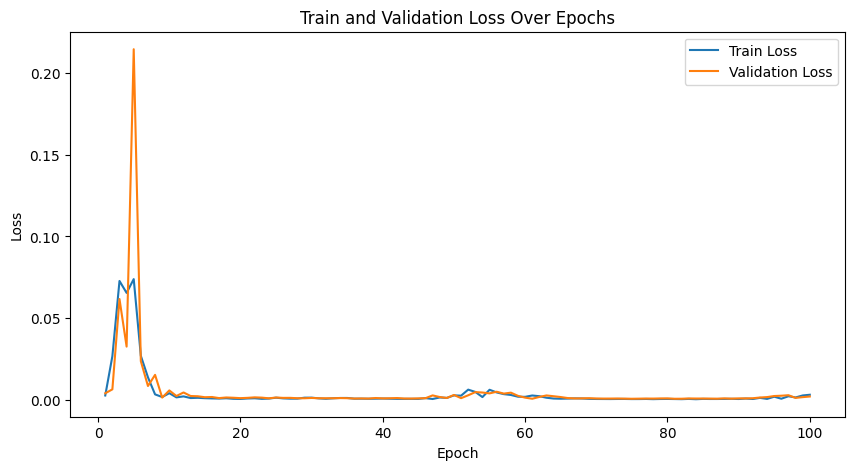

In [10]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

In [11]:
import matplotlib.pyplot as plt
print(len(Y_test))
close_price_true = []
temp_real = []
real = Y_test.detach().cpu().numpy()
for i in range(len(Y_test)):
   temp_real.append(real[i][0])
temp_real = np.array(temp_real)
print(temp_real.shape)
temp_real = temp_real.reshape(-1, 1)
temp_real = np.repeat(temp_real, 4, axis=1)
# print(close_price_true)
temp_real = scaler.inverse_transform(temp_real)
# print(temp_real)
for i in range(len(temp_real)):
   close_price_true.append(temp_real[i][0])
print(close_price_true)


208
(208,)
[np.float32(145.44092), np.float32(143.36897), np.float32(143.96094), np.float32(149.01256), np.float32(151.77518), np.float32(149.57495), np.float32(150.82799), np.float32(148.57841), np.float32(146.51634), np.float32(148.46005), np.float32(150.55173), np.float32(150.94635), np.float32(153.76819), np.float32(152.92952), np.float32(155.29747), np.float32(157.15236), np.float32(155.72173), np.float32(156.80702), np.float32(158.1094), np.float32(156.16571), np.float32(155.5441), np.float32(158.62245), np.float32(160.19124), np.float32(162.69728), np.float32(163.95032), np.float32(163.41754), np.float32(161.57254), np.float32(162.46048), np.float32(159.86562), np.float32(158.65207), np.float32(157.96141), np.float32(163.34848), np.float32(163.00319), np.float32(163.02287), np.float32(164.24629), np.float32(165.39085), np.float32(164.42389), np.float32(162.81567), np.float32(163.12154), np.float32(161.58238), np.float32(161.57254), np.float32(166.16042), np.float32(167.41344), n

[np.float32(157.10477), np.float32(157.21803), np.float32(156.7755), np.float32(155.81422), np.float32(156.34735), np.float32(158.95677), np.float32(160.84465), np.float32(161.98552), np.float32(162.02808), np.float32(160.56999), np.float32(159.32549), np.float32(159.39342), np.float32(160.18466), np.float32(161.94781), np.float32(163.79749), np.float32(165.11174), np.float32(166.28413), np.float32(167.22011), np.float32(167.79886), np.float32(168.19698), np.float32(168.41493), np.float32(168.05019), np.float32(168.55072), np.float32(169.6708), np.float32(171.20839), np.float32(172.82407), np.float32(174.01242), np.float32(173.89757), np.float32(173.3455), np.float32(172.16237), np.float32(171.37762), np.float32(170.90036), np.float32(171.77686), np.float32(173.14888), np.float32(174.15207), np.float32(174.97133), np.float32(175.34671), np.float32(175.31776), np.float32(174.81992), np.float32(174.36317), np.float32(174.09695), np.float32(173.80696), np.float32(174.6311), np.float32(176

C:\Users\N98141062\AppData\Local\Temp\ipykernel_4564\2138207862.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('output/model/aapl/lstm_5.pth')


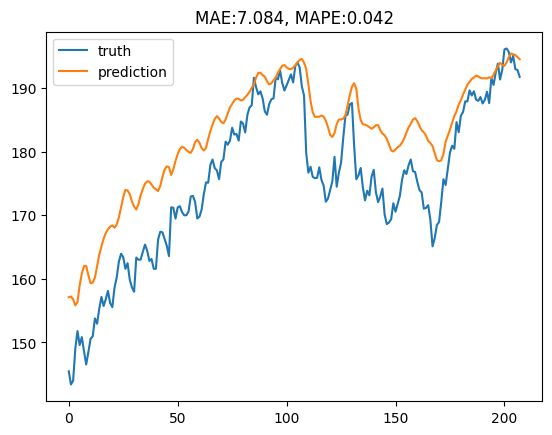

In [12]:
from sklearn.metrics import r2_score

close_price_pred = []
model = torch.load('output/model/aapl/lstm_5.pth')
model.to(device)
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    pred = pred.detach().cpu().numpy()[0]
    pred = pred.reshape(-1, 1)
    # print(pred)
    pred = np.repeat(pred, 4, axis=1)
    pred_inver = scaler.inverse_transform(pred)
    # print(pred_inver[0][0])
    close_price_pred.append(pred_inver[0][0])
print(close_price_pred)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['truth', 'prediction'])
# 輸出所有指標
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

In [13]:
btdf = pd.DataFrame({'close':close_price_true, 'rsi':df['rsi'][-213:-5],'predicted_close':close_price_pred})

In [14]:
btdf =btdf.dropna().reset_index(drop=True)

In [15]:
btdf

,close,rsi,predicted_close
0,145.440918,51.156447,157.104767
1,143.368973,50.113127,157.218033
2,143.960938,45.956782,156.775497
3,149.012558,47.301589,155.814224
4,151.775177,57.109919,156.347351
...,...,...,...
203,194.057312,67.991817,195.469208
204,195.097504,62.680133,195.337677
205,193.007248,64.544443,195.218643
206,192.858658,58.247505,194.914932


買入價格: 143.36897
賣出價格: 196.25655
cash: 1.3688908e+06
額外要扣掉: 5429.0054
扣掉後的: 1.3634618e+06
-------------------------------------
買入價格: 195.0975
賣出價格: 191.78876
最終價格: 1.3403402e+06


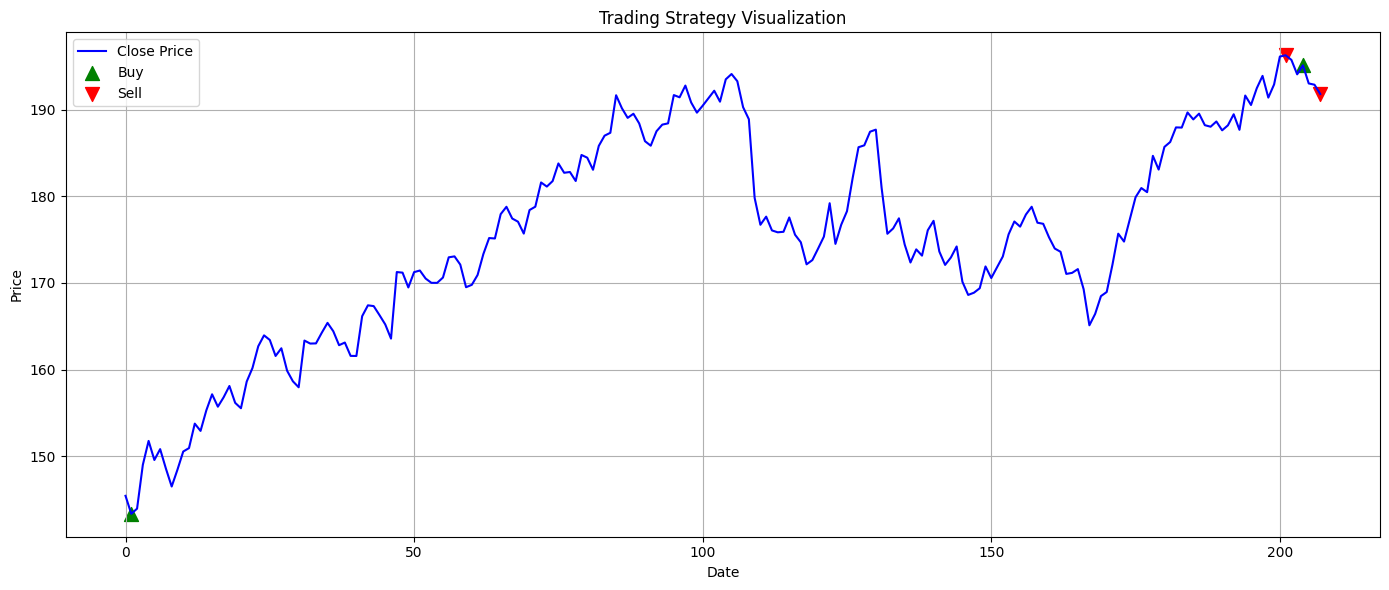

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


買入價格: 143.36897
賣出價格: 191.78876
最終價格: 1.337728e+06


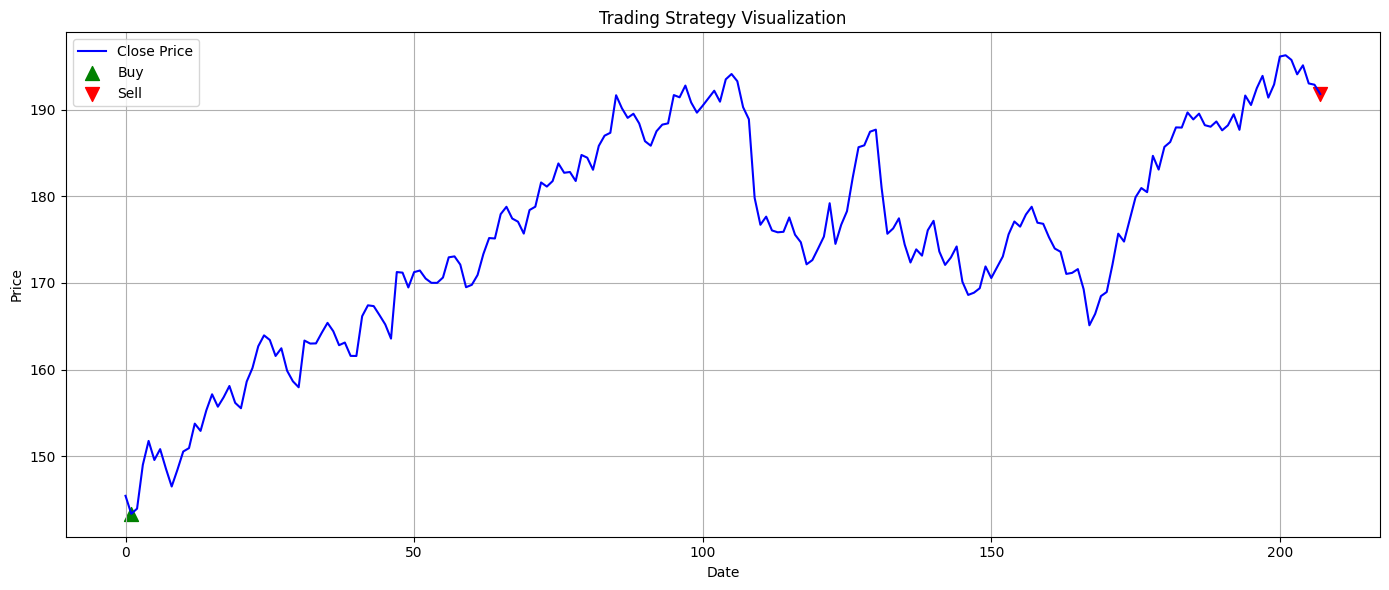

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1.5‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'rsi'] > 76.032 and btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
def preprocess(data_trend, train_ratio, n_past, predict_day):     
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day, 0])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data2 = df[[c for c in df.columns if c not in ['Date','Volume']]].values
X_train, Y_train, X_val, Y_val, X_test, Y_test = preprocess(data2, train_ratio, n_past, predict_day)
Y_test.shape

torch.Size([208, 5])

In [19]:
print(Y_test.shape)
pred_arr = []
#len(test_set)
arr = []
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    pred = pred.detach().cpu().numpy()
    pred = pred.reshape(-1, 1)
    pred = np.repeat(pred, 4, axis=1)
    # print(pred)
    pred_inver = scaler.inverse_transform(pred)
    pred_arr.append(pred_inver[:, 0])
pred_arr = np.array(pred_arr)
pred_arr = torch.tensor(pred_arr)


torch.Size([208, 5])


In [20]:
print(pred_arr.shape)
mae = torch.mean(torch.abs(pred_arr - Y_test))
mape = torch.mean(torch.abs(pred_arr - Y_test)/Y_test)
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

torch.Size([208, 5])
MAE:  7.0115
RMSE: 8.1352
MAPE: 4.1273%
R²:   0.5661


In [ ]:
import csv

csv_filename = 'output/aapl_output.csv'

# 將 Tensor 的值存入 CSV 檔案的第 A 行
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    # 每個值分別寫入每一行
    for value in Y_test[:,0].tolist():
        writer.writerow([value])

print(f"Tensor 已成功存入 {csv_filename} 的每一行！")

# 讀取已經存在的 CSV 檔案，將 Tensor B 的值加到第 A 行右邊的對應行
with open(csv_filename, mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

# 把 Tensor B 的每個元素加到對應行的右邊
for i, value in enumerate(pred_arr[:,0].tolist()):
    rows[i].append(value)

# 寫回更新過的資料
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

print("Tensor B 的每個值已成功加到對應行右邊！")



Tensor 已成功存入 output/output.csv 的每一行！
Tensor B 的每個值已成功加到對應行右邊！


In [22]:

mae = torch.mean(torch.abs(pred_arr[:,4] - Y_test[:,4]))
mape = torch.mean(torch.abs(pred_arr[:,4] - Y_test[:,4])/Y_test[:,4])
print(f"mae: {mae.item()}")
print(f"mape: {mape.item()}")

mae: 6.801589488983154
mape: 0.039876408874988556
